<a href="https://colab.research.google.com/github/Dkreitzer/Text_ML_Classification_UMN/blob/master/Doc_Classification32119.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**bold text**# references
https://towardsdatascience.com/applying-machine-learning-to-classify-an-unsupervised-text-document-e7bb6265f52


# Imports and Installs

In [0]:
#@title Get/Replace Github { output-height: 100, display-mode: "form" }
repo_location = "https://github.com/Dkreitzer/Text_ML_Classification_UMN" #@param {type:"string"}
get_new = True #@param {type:"boolean"}
remove_old = False #@param {type:"boolean"}
repo_name = repo_location.split("/")[-1]
if remove_old:
  double_check = input(
      'Make sure to backup master_data.csv Enter "Delete" to continue? ').lower()
  if double_check == "delete":
      !rm -rf $repo_name
if get_new:
    !git clone $repo_location
    



In [0]:
!pip freeze > Text_ML_Classification_UMN/requirements.txt
!pip install Markdown2

In [0]:
#@title Install packages { output-height: 100, form-width: "45%" }
!pip install -r $repo_name/requirements.txt


In [0]:
#@title  { vertical-output: true }
from __future__ import print_function
from nltk.stem.snowball import SnowballStemmer
import string
from nltk.tag import pos_tag
from gensim import corpora, models, similarities
from sklearn.externals import joblib
from sklearn.metrics import euclidean_distances
from sklearn.metrics.pairwise import cosine_similarity
import colorsys
import markdown2


import seaborn as sns
from scipy.sparse import coo_matrix
from sklearn.metrics import silhouette_samples, silhouette_score
import sys
from operator import itemgetter
import time
from tqdm.auto import tqdm
import re

from datetime import datetime
from nltk.corpus import stopwords
from nltk import word_tokenize, sent_tokenize
from nltk.stem import PorterStemmer
from nltk import pos_tag
import nltk
import math
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib import figure
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans
from sklearn import metrics
from IPython.display import display, HTML

import numpy as np  ##20.2
import pandas as pd
from pandas.io.common import EmptyDataError

import matplotlib
import os
from pathlib import Path
import shutil
import string

import ipywidgets as widgets

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

%matplotlib inline

#Downloading Files


In [0]:
  #@title Move Files for Testing
# !mkdir Text_ML_Classification_UMN/Analyze
# !mkdir Text_ML_Classification_UMN/Predicting/

# !mkdir Text_ML_Classification_UMN/Predicting/CSV
# !mkdir Text_ML_Classification_UMN/Predicting/Images


In [0]:
#@markdown ### get_time() { vertical-output: true }
def get_time():
    current_time = datetime.now().strftime("%b%d-%I%M%p")
    return current_time
get_time()

In [0]:
#@title get_documents() { vertical-output: true }
number_of_docs = 100 #@param {type:"integer"}

def get_documents(NUMBER_OF_DOCS):
    doclist = []
    names = []
    # %cd "
    pathlist = Path(
        "Text_ML_Classification_UMN/Train/Text_Files_Trained").glob('**/*.txt')

    for path in tqdm(pathlist):
        path_in_str = str(path)
    #     print(path_in_str)
        name = path_in_str.split(".")[0].split("/")[3]
        names.append(name.replace("_", " "))
        # TODO SPLIT PATH TO COMPANY NAME, make Index
        file = open(path, "r", encoding= 'Windows-1252')
        # print "Output of Readlines after appending"
        text = file.readlines()
    #     print(text[:10])
        doclist.append(text[0])
      
      
            
    df_to_split = pd.DataFrame(list(zip(names, doclist)),
                               columns=['Company', 'Text'])
    split_df = df_to_split.sample(n=NUMBER_OF_DOCS, random_state=42)
    doclist, names =  split_df["Text"].tolist(), split_df["Company"].tolist()
    print(split_df.head())
    print(str(len(doclist)) + " Documents Loaded!")
    
    
    
    return doclist, names
doclist, names = get_documents(number_of_docs)

# Vectorization
In order to run the model, we need to turn words in to numbers <br>
Finally, we <a href="#Stem">Stem</a>   each token into its word root <br>
Then we can use some sort of <a href="#Vector">Vectorizer</a> to generate our input!


In [0]:
#@title transform_tokens() { vertical-output: true, display-mode: "form" }
#@markdown First, we turn each document into tokens, in our case, I chose to use sentences over words, in order to have a semblance of context in our simpler K-Means Algorithm. If we were to use LSTM or another model that uses sequences we could use a word tokenizer.

def transform_tokens(doclist):
    token_list = []
    for doc in tqdm(doclist, desc="Tokenizing", leave=True, position=0):
        dirty_tokens = nltk.sent_tokenize(doc)
        token_list += [dirty_tokens]
    return token_list
tokens = transform_tokens(doclist)
tokens[0][:5]

In [0]:
#@title transform_filtered() { vertical-output: true, display-mode: "form" }
#@markdown To remove digits, useless words and characters we use a filter. Since we are using a sentence tokenizer, we need to deconstruct, filter, then reconstruct those sentences


def transform_filtered(token_list, doclist, names):

    punc = ['.', ',', '"', "'", '?', '!', ':',
            ';', '(', ')', '[', ']', '{', '}', "%"]
    more_stops = ['\t',
                  '\\t\\t\\', '\\t\\t\\t',
                  '<U+25CF>', '<u+feff>',  '[1]', 'feff', '1a', 'item']
    maybe_bad_stops = ['may', 'could',  'contents',
                       'table', 'time', '25cf', 'factors', 'risk']
    stopwords_list = stopwords.words(
        'english') + more_stops + punc + maybe_bad_stops
    filtered_tokens = []
    names_list = []
    
    if type(token_list) != list:
        token_list = [token_list]
    index = 0
              
    for document in tqdm(token_list, desc="Filtering Documents"):
        name = names[index]
        for token in document:
            filtered_token = [word.lower() for word in token.split(
                " ") if word.lower() not in stopwords_list and word.isalpha()]
            filtered_token = ' '.join(filtered_token)
            if len(filtered_token) != 0:
                names_list.append(name)
                filtered_tokens.append(filtered_token)
        index += 1
    
    return filtered_tokens, names_list, stopwords_list
  
  
filtered_tokens, names_list, stopwords_list = \
transform_filtered(tokens, doclist, names)
filtered_tokens[:25]


In [0]:
#@title transform_stemming() { vertical-output: true, display-mode: "form" }
def transform_stemming(filtered_tokens):
    stemmed = []
    for token in tqdm(filtered_tokens, desc="Stemming"):
        sentence = []
        stemmed_token = \
        [PorterStemmer().stem(word) for word in token.split(" ")]
        stemmed_token = \
        [word for word in stemmed_token if word not in stopwords_list]
#         stemmed_token = \
#         [LancasterStemmer().stem(word) for word in token.split(" ")]
#         stemmed_token = \
#         [SnowballStemmer('english').stem(word) for word in token.split(" ")]

        stemmed_token = ' '.join(stemmed_token)
        stemmed.append(stemmed_token)

    return stemmed

  
stemmed = transform_stemming(filtered_tokens)
stemmed[:5]

In [0]:
#@title transform_vectorize() { vertical-output: true, form-width: "50%", display-mode: "form" }
#@markdown TF-IDF Vectorizer
#@markdown tf–idf or TFIDF, short for term frequency–inverse document frequency, is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus.
#@markdown Term Frequency: the number of times that term t occurs in document d. 
#@markdown The inverse document frequency : how much information the word provides, i.e., if it's common or rare across all documents. It is the logarithmically scaled inverse fraction of the documents that contain the word (obtained by dividing the total number of documents by the number of documents containing the term, and then taking the logarithm of that quotient) <a href="https://en.wikipedia.org/wiki/Tf%E2%80%93idf">Source</a>:
doc_frequency_min = 0.01 #@param {type:"slider", min:0, max:1, step:0.01}
doc_frequency_max = 0.55 #@param {type:"slider", min:0, max:1, step:0.01}


def transform_vectorize(
    stemmed, smallest_ngram, largest_ngram, range_values):

    vectorizer = TfidfVectorizer(stop_words=stopwords_list,
                   ngram_range=(smallest_ngram, largest_ngram),
                   max_df=range_values[1], min_df=range_values[0])
    count_vectorizer = CountVectorizer(stop_words=stopwords_list,
                   ngram_range=(smallest_ngram, largest_ngram),
                   max_df=range_values[1], min_df=range_values[0])
    sparseMatrix = vectorizer.fit_transform(stemmed)
    
    return sparseMatrix, vectorizer, count_vectorizer
 


smallest_ngram = 1
largest_ngram = len(max(tokens, key=len))
%time sparseMatrix, vectorizer, count_vectorizer = \
transform_vectorize(\
    stemmed, smallest_ngram, largest_ngram,\
    (doc_frequency_min, doc_frequency_max))
vectorizer

In [0]:
#@title Matrix as array { vertical-output: true, form-width: "50%", display-mode: "form" }
# vector_array = sparseMatrix.toarray()
# print(vector_array, sparseMatrix.shape)
# count_matrix = count_vectorizer.fit_transform(stemmed).toarray() 
# print(count_matrix, count_matrix.shape)


In [0]:
#@title Visualizing The Vectors { vertical-output: true, form-width: "50%" }
#@markdown this is Plotting the Matix on a blue background, any item in the vocab with a non-zero frequency shows up as a Yellow Dot. In our case, zeros dont effect the accuracy of our K-Means model, but be aware that it may cause issues.
def plot_coo_matrix(m):
    if not isinstance(m, coo_matrix):
        m = coo_matrix(m)
    fig = plt.figure(figsize=(50,50))
    ax = fig.add_subplot(354, facecolor='blue')
    ax.plot(m.col, m.row, 's', color='yellow', markersize=1)
    ax.set_xlim(0, m.shape[1])
    ax.set_ylim(0, m.shape[0])
    ax.set_aspect('auto')
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.invert_yaxis()
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    return ax

 
plot_coo_matrix(sparseMatrix.T).figure.show()
# spy()

# fig = plt.figure()
# ax = fig.add_subplot(354, facecolor='black')


# Model Training

In [0]:
#@markdown ### print_score() { display-mode: "code" }
def print_score(model, vectorizer, stemmed):
    labels = model.labels_

#     print(f"Model Generated at {model_time}")

    print("Cluster id labels for inputted data")
    print(labels)
    print("Centroids data")
    #print (centroids)
    print("Paramaters")
    print(model.get_params)
    sparseMatrix = vectorizer.fit_transform(stemmed)
    kmeans_score = model.score(sparseMatrix)
    print("Score (Opposite of the value of X on the K-means objective, \n",
          "which is Sum of distances of samples to their closest cluster center):")
    print(kmeans_score)

    silhouette_score = metrics.silhouette_score(
        sparseMatrix, labels, metric='euclidean')

    print("Silhouette_score: ", silhouette_score)

    
    
    return kmeans_score, silhouette_score, sparseMatrix


In [0]:
#@title Grid Search { run: "auto", vertical-output: true, display-mode: "form" }
from sklearn.metrics import silhouette_score as sc

max_iter = 10,11 #@param {type:"raw"}
n_clusters = 25, 26, 27, 28, 29, 30, 31,  32, 33, 34, 35 #@param {type:"raw"}

cross_validation_folds = 2 #@param {type:"integer"}
if cross_validation_folds == 0:
  cross_validation_folds=[(slice(None), slice(None))]

def cv_silhouette_scorer(estimator, X):
    estimator.fit(X)
    cluster_labels = estimator.labels_
    num_labels = len(set(cluster_labels))
    num_samples = len(X.index)
    if num_labels == 1 or num_labels == num_samples:
        return -1
    else:
        return sc(X, cluster_labels)

n_jobs = 2 #@param {type:"slider", min:1, max:1000, step:1}
verbose = 2 #@param {type:"slider", min:1, max:10, step:1}
run_gridsearch = False #@param {type:"boolean"}
from sklearn.model_selection import GridSearchCV
if run_gridsearch:
    model = KMeans(init='k-means++', random_state=42, n_init=15
                       )
    param_grid = {'max_iter': list(max_iter),
                 'n_clusters': list(n_clusters),
                  
                 }
    grid = GridSearchCV(model, param_grid, verbose=10, n_jobs=n_jobs,
                        cv=cross_validation_folds, scoring=cv_silhouette_scorer)
    grid.fit(sparseMatrix)

    # lids = model.cluster_centers_

    score = model.score(sparseMatrix)
    silhouette_score = metrics.silhouette_score(sparseMatrix, labels, metric='euclidean')

    # # List the best parameters for this dataset
    print(grid.best_params_)
    # # List the best score
    print(grid.best_score_)

In [0]:
#@markdown ##Kmeans
#@markdown <img src='https://upload.wikimedia.org/wikipedia/commons/d/d5/Kmeans_animation.gif'>
#@markdown An example of how cluster centroids move over time, see <a href="dimension_reduction"> Dimension Reduction</a> for actual visualizations of our clusters
def estimator_cluster(sparseMatrix, vectorizer, params):
    model = KMeans(n_clusters=params['n_clusters'], init=params['init'],
                   max_iter=params['max_iter'], n_init=n_init,
                   random_state=params['random_state'],
                   precompute_distances = params['precompute_distances'],
                   verbose=params['verbose'], 
#                    n_jobs=params['n_jobs']
)
    model.fit(sparseMatrix)

    
    model_time = get_time()
    model_path = f'Text_ML_Classification_UMN/Model/model{model_time}.pkl'
    joblib.dump(model,  model_path)
    joblib.dump(vectorizer,  f'Text_ML_Classification_UMN/Model/vec{model_time}.pkl')
    order_centroids = model.cluster_centers_.argsort()[:, ::-1]
#     order_centroids = False
    terms = vectorizer.get_feature_names()
    print('Model Saved to %s' % model_path)
    return terms, order_centroids, model, n_clusters, model_time

In [0]:
#@title Model Parameters { run: "auto" }
init = "k-means++" #@param ["Pre-Labeled",'k-means++']
if init == "Pre-Labeled":
  init = get_topics(topics)
  n_clusters = init.shape[0]
else:
  n_clusters = 35 #@param {type:"integer"}

max_iter=50  #@param {type:"integer"}
n_init= 10 #@param {type:"slider", min:0, max:100, step:1}
random_state=42  #@param {type:"integer"}
save_memory = False #@param ["False", "True"] {type:"raw"}
verbose = 0 #@param {type:"slider", min:0, max:10, step:1}
# n_jobs = 1 #@param {type:"slider", min:1, max:100, step:1}



params = {"n_clusters" : n_clusters, "max_iter" : max_iter,
          'n_init' : n_init, 'random_state': random_state,
          'precompute_distances': save_memory, 'init': init,
         'verbose' : verbose, 
#           'n_jobs': n_jobs
         }


In [0]:
#@title Generate Model { vertical-output: true, output-height: 250 }
#@markdown #### Q.) This takes a long time so why not use a Hashing technique?
#@markdown #### A.)  We would not be able to get the vocab back, critical for this unsupervised problem, however we may implemetn a Dimension Reduction Techinuqe eventually, see That Section below for more info.

%time terms, order_centroids, model, n_clusters, model_time =  \
  estimator_cluster(sparseMatrix, vectorizer, params)
# kmeans_score, silhouette_score, sparseMatrix = print_score(model,vectorizer,stemmed)

In [0]:
#@title Move Files? { display-mode: "form" }

train_to_history = False #@param {type:"boolean"}
analyze_to_history = False #@param {type:"boolean"}
train_to_analyze = False #@param {type:"boolean"}


def move_txt_files(analysis_to_history, train_to_history, train_to_analyze):
    if train_to_history or train_to_analyze:
        print("From Train")
        pathlist = Path(
            "Text_ML_Classification_UMN/Train/Text_Files_Trained").glob('**/*.txt')
     
    if analyze_to_history:
        print("From Analyze")
        pathlist = Path(
            "/Text_ML_Classification_UMN/Analyze").glob('**/*.txt')
    
    if analyze_to_history or train_to_history:
      print("To History")
      for path in tqdm(pathlist):
            shutil.move(str(path), 'Text_ML_Classification_UMN/History/Text_Files_History')
    
    if train_to_analyze:
        print("To Analyze")
        for path in tqdm(pathlist):
            shutil.move(str(path), 'Text_ML_Classification_UMN/Analyze')

move_txt_files(analyze_to_history, train_to_history, train_to_analyze)

# Loading Model

In [0]:
#@markdown ### load master_data() { display-mode: "form" }
def load_master_data():
    master_path = 'Text_ML_Classification_UMN/Predicting/CSV/master_data.csv'
    try:
        master = pd.read_csv(master_path)
        master = master.set_index('label')
    except FileNotFoundError:
        master = False
    
    return master

In [0]:
#@markdown ### estimator_load_model()
def estimator_load_model(selection, stemmed):
      print(selection)
      model_time = selection
      vectorizer = joblib.load(
          f'Text_ML_Classification_UMN/Model/vec{model_time}.pkl')
      model = joblib.load(
          f'Text_ML_Classification_UMN/Model/model{model_time}.pkl')
#       if stemmed:
#           kmeans_score, silhouette_score, sparseMatrix = \
#             print_score(model, vectorizer, stemmed)
      n_clusters = model.n_clusters
      
      return model, vectorizer, n_clusters

In [0]:
#@markdown ### generate colormap() { display-mode: "form" }
#@markdown  <a href='https://stackoverflow.com/questions/876853/generating-color-ranges-in-python'>source</a>

def get_N_HexCol(N):
    HSV_tuples = [(x * 1.0 / N, 0.5, 0.5) for x in range(N)]
    hex_out = []
    for rgb in HSV_tuples:
        rgb = map(lambda x: int(x * 255), colorsys.hsv_to_rgb(*rgb))
        hex_out.append('#%02x%02x%02x' % tuple(rgb))
    return hex_out

In [0]:
#@title Model Selection { run: "auto", vertical-output: true, display-mode: "form" }

pathlist = Path(
        "Text_ML_Classification_UMN/Model/").glob('**/*.pkl')


times = [str(path).split(".pkl")[0].split("/")[2].replace(
        "model", "").replace("vec", "") for path in pathlist]
times.reverse()


selection = widgets.Dropdown(
        options=set(times),
        description='Available Models:',
        disabled=False,
    )
display(selection)


Dropdown(description='Available Models:', options=('Feb14-0130PM', 'Mar21-0320PM', 'Mar21-0310PM'), value='Feb…

In [0]:
time = selection.value
model, vectorizer, n_clusters = estimator_load_model(time, stemmed)

Mar21-0320PM


In [0]:
#@title Define Cluster Labels { run: "auto", vertical-output: true, display-mode: "form" }
num_words_to_show = 8 #@param {type:"slider", min:1, max:25, step:1}

order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()



colormap = get_N_HexCol(n_clusters)



for label in range(n_clusters):
    nclosest_words = []
    color = colormap[label]
    display(HTML(f'<font color="{color}">Cluster {label}</font>'))
    for ind in order_centroids[label, :num_words_to_show]:
       nclosest_words.append(terms[ind])
    display(HTML(f'<font color="{color}">{nclosest_words}</font>'))

    

# Predictions

In [0]:
#@title Predict String() { run: "auto", vertical-output: true, display-mode: "form" }

def estimator_predict_string(string):
    string_in_a_list = ["string"]
    
    print('Input String: %s' % string)
    print('\n')
    print('Prediction:')
    tokens = transform_tokens(string_in_a_list)
    filtered_tokens, _ , _ = transform_filtered(tokens, string_in_a_list, string_in_a_list)
    stemmed = transform_stemming(filtered_tokens)
    vector_matrix = vectorizer.transform(stemmed)
    predicted = model.predict(vector_matrix)



    color = colormap[predicted[0]]
    display(HTML(f'<font color="{color}">Predicted Cluster : {predicted[0]}</font>'))
    for ind in order_centroids[predicted[0], :10]:
       nclosest_words.append(terms[ind])
    display(HTML(f'<font color="{color}">{nclosest_words}</font>'))

    


Enter_a_String = 'Additional risks and uncertainties not presently known to us or that we currently deem immaterial may also affect our business!' #@param {type:"string"}

estimator_predict_string(Enter_a_String)

Input String: Additional risks and uncertainties not presently known to us or that we currently deem immaterial may also affect our business!


Prediction:


In [0]:
#@title Potential Topics { vertical-output: true }

#@markdown SUMMARIZATION OF CORPORATE RISK FACTOR DISCLOSURE THROUGH TOPIC MODELING by Bao, Datta
strings = [
    'Topic 0: investment, property, distribution, interest, agreement',
    'Topic 1: regulation, change, law, financial, operation, tax, accounting ',
    'Topic 2: gas, price, oil, natural, operation, production Input prices risks ',
    'Topic 3: stock, price, share, market, future, dividend, security, stakeholder ',
    'Topic 4: cost, regulation, environmental, law, operation, liability',
    'Topic 5: control, financial, internal, loss, reporting, history ',
    'Topic 6: financial, litigation, operation, condition, action, legal, liability, regulatory, claim, lawsuit'
    'Topic 7: competitive, industry, competition, highly',
    'Topic 8: cost, operation, labor, operating, employee, increase, acquisition ',
    'Topic 9: product, candidate, development, approval, clinical, regulatory',
    'Topic 10: tax, income, asset, net, goodwill, loss, distribution, impairment, intangible ',
    'Topic 11: interest, director, officer, trust, combination, share, conflict ',
    'Topic 12: product, liability, claim, market, insurance, sale, revenue Potential defects in products',
    'Topic 13: loan, real, estate, investment, property, market, loss, portfolio ',
    'Topic 14: personnel, key, retain, attract, management, employee ',
    'Topic 15: stock, price, operating, stockholder, fluctuate, interest, volatile  ',
    'Topic 16: acquisition, growth, future, operation, additional, capital, strategy ',
    'Topic 17: condition, economic, financial, market, industry, change, affected, downturn, demand Macroeconomic risks ',
    'Topic 18: system, service, information, failure, product, operation, software, network, breach, interruption Disruption of operations'
    'Topic 19: cost, contract, operation, plan, increase, pension, delay',
    'Topic 20: customer, product, revenue, sale, supplier, relationship, key, portion, contract, manufacturing, rely Rely on few large customers',
    'Topic 21: property, intellectual, protect, proprietary, technology, patent, protection, harm',
    'Topic 22: product, market, service, change, sale, demand, successfully, technology, competition Volatile demand and results',
    'Topic 23: provision, law, control, change, stock, prevent, stockholder, Delaware, charter, delay, bylaw',
    'Topic 24: regulation, government, change, revenue, contract, law, service',
    'Topic 25: capital, credit, financial, market, cost, operation, rating, access, liquidity, downgrade ',
    'Topic 26: debt, indebtedness, cash, obligation, financial, credit, ',
    'Topic 27: operation, international, foreign, currency, rate, fluctuation',
    'Topic 28: loss, insurance, financial, loan, reserve, operation, cover',
    'Topic 29: operation, natural, facility, disaster, event, terrorist, weather ']
topics = [topic.split(":")[1] for topic in strings]
targets = {
    "Shareholder’s interest risk": topics[0],
    "Regulation changes(accounting)": topics[1],
    "Stakeholder’s profit": topics[2],
    "Regulation changes(environment)": topics[3],
    "Legal Risks": topics[4],
    "Financial condition risks ": topics[5],
    " Potential/Ongoing Lawsuits": topics[6],
    "market Competition risks": topics[7],
    "**Labor cost ": topics[8],
    " New product introduction risks ": topics[9],
    "**Accounting,  +Restructuring risks ": topics[10],
    "**Management": topics[11],
    " Potential defects in products": topics[12],
    "**Investment": topics[13],
    "Human resource risks": topics[13],
    "Volatile stock price risks": topics[14],
    "Merger & Acquisition risks": topics[15],
    " +Industry is cyclical": topics[16],
    " **Postpone ":  topics[17],
    " +Infrastructure risks": topics[18],
    "+Suppliers risks +Downstream risks": topics[19],
    "license Intellectual property risks": topics[20],
    "+Licensing related risks' ": topics[21],
    "+ Competition risks ": topics[22],
    "*Potential/Ongoing Lawsuits*": topics[23],
    "Regulation changes": topics[24],
    "Credit risks": topics[25],
    "covenant Funding risks ": topics[26],
    "International risks": topics[27],
#     "Insurance" : topics[28],
#     "Catastrophes" : topics[29]
}

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

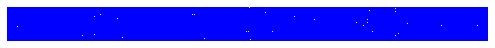

In [0]:
#@title get_topics() { vertical-output: true }
def get_topics(topics):
  string_in_a_list = np.empty([len(topics),1], dtype=str)
  tokens = transform_tokens(topics)
  filtered_tokens, _ , _ = transform_filtered(tokens, string_in_a_list, string_in_a_list)
  stemmed = transform_stemming(filtered_tokens)
  cluster_origins = vectorizer.transform(stemmed)
  plot_coo_matrix(cluster_origins)
  cluster_origins = cluster_origins.toarray()
  return cluster_origins
get_topics(targets)

# Predict Documents

In [0]:
#@title predict_document() { display-mode: "form" }
def predict_document(document, name):
    dictionary_list = []
    for counter, sentence in enumerate(document.split(".")):
        if len(sentence) != 0:
            vector_matrix = vectorizer.transform([sentence])
            predicted_label = model.predict(vector_matrix)
            sentence_len = len(sentence.split(" "))
            sentence_info = {'company': name, 'sentence#': counter, 'text': sentence,
                             'wordcount': sentence_len, 'label': predicted_label[0]}
            dictionary_list.append(sentence_info)
    dataframe = pd.DataFrame(dictionary_list)
    dataframe["% of total"] = dataframe['wordcount'] / \
        sum(dataframe['wordcount'])
#         (name, sentence, predicted_label)
    return(dataframe)
def prep_for_heatmap(muliple_company_frame):
    company_clusters = muliple_company_frame.groupby(['label', 'company']).agg(
        {'% of total': 'sum'}).unstack(level='company').fillna(0).T

    company_clusters = company_clusters.reset_index(level=0, drop=True)
    return company_clusters


In [0]:
#@title Default title text
docs_to_move = 100 #@param {type:"slider", min:0, max:3000, step:1}
pathlist = Path(
    "Text_ML_Classification_UMN/%s" % "Train/Text_Files_Trained").glob('**/*.txt')
# try:
counter = 1
for path in tqdm(pathlist, desc="Reading Lines"):
  counter += 1
  if counter < docs_to_move:
    path_in_str = str(path)
    shutil.move(path_in_str, 'Text_ML_Classification_UMN/Analyze')


In [0]:
#@title analyze_folder() { run: "auto", vertical-output: true, display-mode: "form" }
folder_choice =  'Analyze' #@param ["Analyze", "Sandbox"] {allow-input: true}


#@markdown Save Documents?
To_Master_List = True #@param ["False", "True"] {type:"raw"}
To_New_List =  True #@param ["False", "True"] {type:"raw"}

def analyze_folder():
  doclist = []
  names = []
  # %cd "
  pathlist = Path(
      "Text_ML_Classification_UMN/%s" % folder_choice).glob('**/*.txt')
# try:
  for path in tqdm(pathlist, desc="Reading Lines"):
      path_in_str = str(path)
  #     print(path_in_str)
      name = path_in_str.split(".")[0].split("/")[2]
      names.append(name.replace("_", " "))
      # TODO SPLIT PATH TO COMPANY NAME, make Index
      file = open(path, "r", encoding= 'Windows-1252')
      # print "Output of Readlines after appending"
      text = file.readlines()
      doclist.append(text[0])



  analysis_df = pd.DataFrame(list(zip(names, doclist)),
                             columns=['Company', 'Text'])

  analysis_df 

  frames = []
  
  for document, name in tqdm(zip(doclist, names), desc='Files Processed'):
      frame = predict_document(document, name)
      frames.append(frame)

  muliple_company_frame = pd.concat(frames)
  muliple_company_frame.head()
  grouped_frame = muliple_company_frame.groupby(
    ['company', 'label']).agg({'% of total': 'sum'})
  company_clusters = prep_for_heatmap(muliple_company_frame)
  master_path = "Text_ML_Classification_UMN/Predicting/CSV/master_data.csv"
  master = load_master_data()
  
  if not os. path. isfile(master_path) and To_Master_List == True:
      company_clusters.T.to_csv(master_path, header=True,index=True)
  master = load_master_data()

  if type(master) == "pd.DataFrame" and To_Master_List == True:
      master = pd.concat([master, company_clusters.T], ignore_index=True)
      master.to_csv(master_path, index=True)


      # if file does not exist write header 
      
#       with open(master_path, 'a') as f:
#           company_clusters.to_csv(f, header=f.tell()==0)
      
      ##!! THIS IS CAUSING DUPLICATES ##
      
      
       
    
  if To_New_List == True:
    analysis_time = get_time()

    with open(f'Text_ML_Classification_UMN/Predicting/CSV/{analysis_time}.csv', 'w') as f:
        company_clusters.T.to_csv(f, header=True)
#   except IndexError:
#     print("Are there any files in /Analyze?")
#     company_clusters, grouped_frame = len(names), False
  return company_clusters, grouped_frame, muliple_company_frame, master
company_clusters, grouped_frame, muliple_company_frame, master = analyze_folder()
company_clusters.T.head(20)


company,Accelerate Diagnostics Inc,Acer Therapeutics Inc,Amphastar Pharmaceuticals Inc,Apogee Enterprises Inc,Arch Capital Group Ltd,Arena Pharmaceuticals Inc,BMC Stock Holdings Inc,Bar Harbor Bankshares Inc,CECO Environmental Corp,CNX Resources Corporation,...,Toro Company The,Transatlantic Petroleum Ltd,Trinity Place Holdings Inc,U S Auto Parts Network Inc,Ultragenyx Pharmaceutical Inc,Union Bankshares Corporation,Varex Imaging Corporation,Visa Inc,WidePoint Corporation,eMagin Corporation
label,,,,,,,,,,,,,,,,,,,,,
1,0.001454,0.000931,0.005133,0.000000,0.013489,0.001021,0.007961,0.009286,0.006918,0.002445,...,0.009656,0.006436,0.002626,0.004482,0.002975,0.005914,0.013053,0.000000,0.005937,0.002945
2,0.506784,0.376011,0.445188,0.479219,0.526923,0.530856,0.407929,0.434995,0.426224,0.481831,...,0.423233,0.522265,0.414182,0.467792,0.394552,0.463719,0.493740,0.521482,0.544718,0.513360
3,0.000000,0.003759,0.005102,0.000000,0.007343,0.001123,0.002171,0.009042,0.000000,0.004890,...,0.000000,0.001839,0.002935,0.006767,0.004661,0.001596,0.006696,0.012431,0.006597,0.005235
4,0.010297,0.019656,0.008368,0.051122,0.012238,0.019856,0.021309,0.019795,0.012323,0.034851,...,0.025782,0.015500,0.002626,0.033131,0.016429,0.023655,0.018148,0.010982,0.031194,0.015051
7,0.002726,0.001969,0.002551,0.000000,0.007234,0.005666,0.006755,0.008798,0.009945,0.004890,...,0.002993,0.014712,0.003708,0.000000,0.002876,0.000000,0.008880,0.000000,0.004806,0.005780
9,0.007995,0.007805,0.017296,0.023275,0.029153,0.007554,0.039161,0.051320,0.018593,0.029674,...,0.034473,0.035466,0.020392,0.030758,0.006710,0.047029,0.038965,0.013275,0.011780,0.020504
12,0.005875,0.010276,0.007777,0.000000,0.008104,0.004135,0.004503,0.005865,0.003459,0.004698,...,0.010236,0.019966,0.000000,0.002988,0.005719,0.005444,0.009851,0.012431,0.005655,0.000000
13,0.000000,0.000000,0.003360,0.002909,0.000000,0.001225,0.004021,0.000000,0.006594,0.002253,...,0.000000,0.010114,0.008342,0.008700,0.001157,0.022060,0.000000,0.000000,0.001885,0.002072
15,0.067898,0.088042,0.044765,0.000000,0.000000,0.051197,0.000000,0.000000,0.004648,0.000000,...,0.006856,0.000000,0.000000,0.004921,0.064789,0.000000,0.005144,0.000000,0.000000,0.015705


In [0]:
master
# frame

,Accelerate Diagnostics Inc,Acer Therapeutics Inc,Amphastar Pharmaceuticals Inc,Apogee Enterprises Inc,Arch Capital Group Ltd,Arena Pharmaceuticals Inc,BMC Stock Holdings Inc,Bar Harbor Bankshares Inc,CECO Environmental Corp,CNX Resources Corporation,...,Toro Company The,Transatlantic Petroleum Ltd,Trinity Place Holdings Inc,U S Auto Parts Network Inc,Ultragenyx Pharmaceutical Inc,Union Bankshares Corporation,Varex Imaging Corporation,Visa Inc,WidePoint Corporation,eMagin Corporation
label,,,,,,,,,,,,,,,,,,,,,
1,0.001454,0.000931,0.005133,0.000000,0.013489,0.001021,0.007961,0.009286,0.006918,0.002445,...,0.009656,0.006436,0.002626,0.004482,0.002975,0.005914,0.013053,0.000000,0.005937,0.002945
2,0.506784,0.376011,0.445188,0.479219,0.526923,0.530856,0.407929,0.434995,0.426224,0.481831,...,0.423233,0.522265,0.414182,0.467792,0.394552,0.463719,0.493740,0.521482,0.544718,0.513360
3,0.000000,0.003759,0.005102,0.000000,0.007343,0.001123,0.002171,0.009042,0.000000,0.004890,...,0.000000,0.001839,0.002935,0.006767,0.004661,0.001596,0.006696,0.012431,0.006597,0.005235
4,0.010297,0.019656,0.008368,0.051122,0.012238,0.019856,0.021309,0.019795,0.012323,0.034851,...,0.025782,0.015500,0.002626,0.033131,0.016429,0.023655,0.018148,0.010982,0.031194,0.015051
7,0.002726,0.001969,0.002551,0.000000,0.007234,0.005666,0.006755,0.008798,0.009945,0.004890,...,0.002993,0.014712,0.003708,0.000000,0.002876,0.000000,0.008880,0.000000,0.004806,0.005780
9,0.007995,0.007805,0.017296,0.023275,0.029153,0.007554,0.039161,0.051320,0.018593,0.029674,...,0.034473,0.035466,0.020392,0.030758,0.006710,0.047029,0.038965,0.013275,0.011780,0.020504
12,0.005875,0.010276,0.007777,0.000000,0.008104,0.004135,0.004503,0.005865,0.003459,0.004698,...,0.010236,0.019966,0.000000,0.002988,0.005719,0.005444,0.009851,0.012431,0.005655,0.000000
13,0.000000,0.000000,0.003360,0.002909,0.000000,0.001225,0.004021,0.000000,0.006594,0.002253,...,0.000000,0.010114,0.008342,0.008700,0.001157,0.022060,0.000000,0.000000,0.001885,0.002072
15,0.067898,0.088042,0.044765,0.000000,0.000000,0.051197,0.000000,0.000000,0.004648,0.000000,...,0.006856,0.000000,0.000000,0.004921,0.064789,0.000000,0.005144,0.000000,0.000000,0.015705


# Visualizations


In [0]:
#@title Stacked Bar { run: "auto", display-mode: "form" }
folder = 'Master' #@param ["Analyze", "Master"]
html = True #@param ["False", "True"] {type:"raw"}
png= True #@param ["False", "True"] {type:"raw"}
display_type = "Companies" #@param ["Companies", "Clusters"]

sort_company_display = 'Bottom Companies' #@param ["False", "Top Companies", "Bottom Companies"]
sort_cluster_id = 1 #@param {type:"slider", min:0, max:35, step:1}
sort_cluster_id = str(sort_cluster_id)
if display_type == 'Clusters':
  sort_company_display = 'False'
#@markdown You may want to disable this if visuzaling 15+ Comapnies
display_company_names = True #@param {type:"boolean"}
f = plt.figure()
colors = colormap




if folder == "Master":
  master = load_master_data()
  bar_clusters = master.T
else:
   bar_clusters = company_clusters
    

if sort_company_display != 'False':
#     print(colors[sort_cluster_id])
#     colors[sort_cluster_id] = colormap[sort_cluster_id]
#     print(colors[sort_cluster_id])
  bar_clusters.columns = bar_clusters.columns.map(str)
  if sort_company_display == 'Top Companies':
    ascending = False
  if sort_company_display == 'Bottom Companies': 
    ascending = True
  try: 
    bar_clusters = bar_clusters.sort_values(
        kind='mergesort', by=[sort_cluster_id], axis=0, ascending=ascending).head(10)
  except KeyError:
    print("Cluser out of bounds, try a lower number")
#     bar_clusters['int_index'] = range(len(bar_clusters))

# df.plot(x='int_index', y='sorted_values')
#   except KeyError:
#     print(f"{sort_cluster_id} is an empty cluster, try another")

if not display_company_names:
  ax1 = plt.axes()
  x_axis = ax1.axes.get_xaxis()
  x_axis.set_visible(False)



if display_type == "Companies":
  bar_clusters = bar_clusters.astype(float).T
#     bar_clusters.plot(kind='bar', stacked=True, figsize=(15,10), 
#                       color=colors, use_index=True, ax=f.gca())
# else:
bar_clusters.T.plot(kind='bar', stacked=True, figsize=(15,10), 
                      color=colors, use_index=True, ax=f.gca())
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))


time = get_time()

if png == True or html == True:
  plt.savefig(f'Text_ML_Classification_UMN/Predicting/Images/stackedBar{time}.png')

if html == True:
  print("Make sure Png is located in Text_ML_Classification_UMN/Predicting/Images/ for html to work")
  Html_file= open(f'Text_ML_Classification_UMN/Predicting/Images/stackedBar{time}.html',"w")
  html_str = HTML(
      f'<img src="Text_ML_Classification_UMN/Predicting/Images/stackedBar{time}.png" alt={company_clusters.T.columns.values}>')
  Html_file.close()



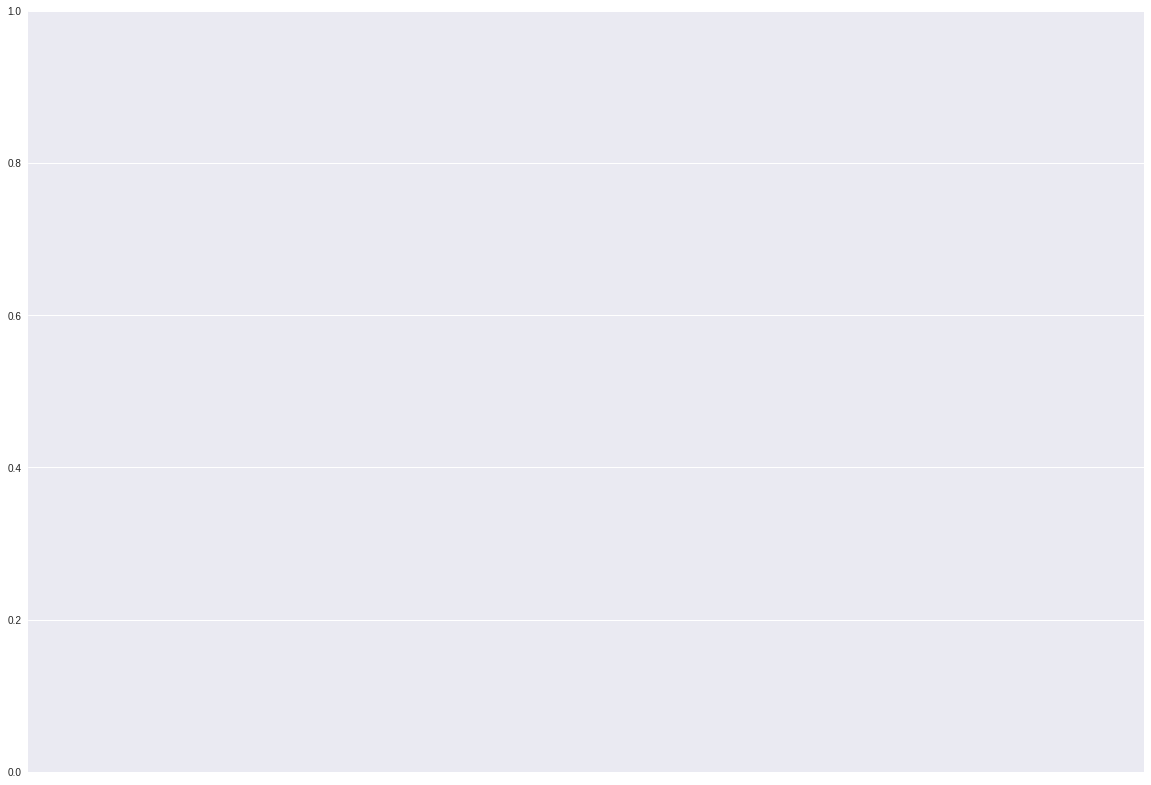

In [0]:
#@title Heatmap { run: "auto", display-mode: "form" }
folder = 'Master CSV' #@param ["Analyze", "Master CSV"]
#@markdown ## Save Image?
html = True #@param ["False", "True"] {type:"raw"}
png= True #@param ["False", "True"] {type:"raw"}
#@markdown You may want to disable this if visuzaling 15+ Comapnies
display_company_names = False #@param {type:"boolean"}


def plot_heatmap(company_clusters, html, png):
    map_time = get_time()

    fig2, ax2 = plt.subplots(figsize=(20, 14))
    cmap = sns.light_palette('red', as_cmap=True)
    if folder == "Master CSV":
      master = load_master_data()
      company_clusters = master.reset_index(drop=True)

    company_clusters.plot(kind='bar', stacked=True, figsize=(15,10), use_index=True, ax=f.gca())

    sns.heatmap(company_clusters, ax=ax2, cmap=cmap)
    

    ax2.set_xlabel('Label', fontdict={'weight': 'bold', 'size': 14})
    ax2.set_ylabel('Company', fontdict={'weight': 'bold', 'size': 14})
    for label in ax2.get_xticklabels():
        label.set_size(16)
        label.set_weight("bold")
    for label in ax2.get_yticklabels():
        label.set_size(16)
        label.set_weight("bold")

    if not display_company_names:
      ax1 = plt.axes()
      x_axis = ax1.axes.get_xaxis()
      x_axis.set_visible(False)
    if png == True or html == True:
        plt.savefig(
        "Text_ML_Classification_UMN/Predicting/Images/Heatmap{map_time}.jpg",
        dpi=None, facecolor='w', edgecolor='w',
                orientation='portrait', papertype=None, format=None,
                transparent=False, bbox_inches=None, pad_inches=0.1,
                frameon=None, metadata=None)

    if html == True:
        Html_file= open('Text_ML_Classification_UMN/Predicting/Images/Heat'+
                        f'map{time}.html',"w")
        html_str = HTML(
            '<img src="Text_ML_Classification_UMN/Predicting/Images/Heat' + 
            f'map{time}.png" alt={company_clusters.T.columns.values}>')
        Html_file.close()



plot_heatmap(company_clusters.T, html, png)


In [0]:
#@title Generate Color Coded Text (Html) { vertical-output: true, display-mode: "form" }
#@markdown Save Text?
html = True #@param ["False", "True"] {type:"raw"}
display_all = False #@param {type:"boolean"}
display_lines = 10 #@param {type:"integer"}


for counter, company in enumerate(muliple_company_frame['company'].unique()):
  company = muliple_company_frame['company'].unique()[counter]
  companyFrame = muliple_company_frame[muliple_company_frame['company'] == company]
  if html == True:
      Html_file= open(f'Text_ML_Classification_UMN/Predicting/Text_Files/{company.replace(" ", "_")}_CC.html',"w")
  display(HTML(f'<h2>{company}</h2>'))


  
  for row in companyFrame.iterrows():
    
    color = colormap[row[1]['label']]
    text = row[1]['text']                
    html_str = HTML(f'<font color="{color}">' +
                       text + f'  ({row[1]["label"]})' + '</font>')
    if row[0] <= display_lines or display_all == True:
        display(html_str)
  if html == True:
    Html_file.close()

In [0]:
#@markdown ## Polar Plots per Cluster


import matplotlib.pyplot as plt
import pandas as pd
from math import pi
# ------- ref  https://python-graph-gallery.com/392-use-faceting-for-radar-chart/
# ------- PART 1: Define a function that do a plot for one line of the dataset!
spider_clusters = company_clusters
spider_clusters['company'] = spider_clusters.index
spider_clusters = spider_clusters.reset_index(drop=True)
spider_clusters.columns = spider_clusters.columns.map(str)

def make_spider( row, title, color):

    # number of variable
    categories=list(df)[1:]
    N = len(categories)

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Initialise the spider plot
    ax = plt.subplot(2,2,row+1, polar=True, )

    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories, color='grey', size=8)

    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([.2,.4,.6], ["20%","40%","60%"], color="grey", size=7)
    plt.ylim(0,.8)

    # Ind1
    values=df.loc[row].drop('company').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0)

    # Add a title
    plt.title(title, size=11, color='black', y=1.1)

    

In [0]:
#@title  { run: "auto" }
cluster_id = 2 #@param {type:"slider", min:1, max:35, step:1}
cluster_id = str(cluster_id)
sort = 'Top Companies' #@param ["Top Companies", "Bottom Companies"]

#@markdown A Radar chart or Spider plot or Polar chart or Web chart allows to study the feature of one or several individuals for several numerical variables
#@markdown #### When to use a spider chart:
#@markdown  1. small-to-moderate-sized multivariate data sets
#@markdown  2. to Identify Outliers
#@markdown  3. to identify what observations are most similar
#@markdown #### In this case:
#@markdown Polar plots were not as effective as the heatmap due to the large number of observations 

spider_clusters = company_clusters
spider_clusters['company'] = spider_clusters.index
spider_clusters = spider_clusters.reset_index(drop=True)
spider_clusters.columns = spider_clusters.columns.map(str)
try:
  spider_clusters = spider_clusters[spider_clusters[cluster_id] != 0]
except KeyError:
  print(f"{cluster_id} is an empty cluster, try another")
  cluster_id = str(company_clusters.columns[0])


if sort == 'Top Companies':
  ascending = False
else: 
  ascending = True
# ------- PART 2: Apply to all individuals
# initialize the figure
my_dpi=100
plt.figure(figsize=(1000/my_dpi, 1000/my_dpi), dpi=my_dpi)
plt.subplots_adjust(left=None, bottom=0.1, right=None,
                    top=0.6, wspace=.3, hspace=.5)

# Create a color palette:
my_palette = plt.cm.get_cmap("Set2", len(spider_clusters.index))

spider_clusters = spider_clusters.sort_values(
    kind='mergesort', by=[cluster_id], axis=0, ascending=ascending)


df = spider_clusters.head(4)
# Loop to plot
for row in range(0, len(df.index)):
    try:
      make_spider( row=row, title='Company '+df['company'][row], color=my_palette(row))
    except KeyError:
      pass

<Figure size 1000x1000 with 0 Axes>

# Dimension Reduction and Cluster Visualization

In [0]:
#@markdown <a id='dimension_reduction'></a>
#@title t-distributed Stochastic Neighbor Embedding { vertical-output: true, output-height: 200, display-mode: "form" }
#@markdown t-SNE  is a tool to visualize high-dimensional data. It converts similarities between data points to joint probabilities and tries to minimize the Kullback-Leibler divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data. t-SNE has a cost function that is not convex, i.e. with different initializations we can get different results.
#@markdown It is highly recommended to use another dimensionality reduction method (e.g. PCA for dense data or TruncatedSVD for sparse data) to reduce the number of dimensions to a reasonable amount (e.g. 50) if the number of features is very high
#@markdown ###  Kullback-Leibler divergence
#@markdown For discrete probability distributions  P and Q is defined to be
#@markdown <img src='https://wikimedia.org/api/rest_v1/media/math/render/svg/726edcd02293461b82768ea2fd299c3a3ef16112'>





from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD

model_tf_idf_cosine = NearestNeighbors(metric='cosine', algorithm='auto')
model_tf_idf_cosine.fit(sparseMatrix)
tfs_reduced_cosine = TruncatedSVD(\
    n_components=n_clusters, random_state=0).fit_transform(sparseMatrix)
%time tfs_embedded_cosine = TSNE(\
    n_components=2, perplexity=40, verbose=0).fit_transform(tfs_reduced_cosine)

model_tf_idf_correlation = NearestNeighbors(
    metric='cityblock', algorithm='auto')
model_tf_idf_correlation.fit(sparseMatrix)
tfs_reduced_correlation = TruncatedSVD(\
    n_components=n_clusters, random_state=0).fit_transform(sparseMatrix)
%time tfs_embedded_correlation = TSNE(\
    n_components=2, perplexity=40, verbose=0).fit_transform(tfs_reduced_correlation)


model_tf_idf_euclidean = NearestNeighbors(metric='euclidean', algorithm='auto')
model_tf_idf_euclidean.fit(sparseMatrix)
tfs_reduced_euclidean  = TruncatedSVD(\
    n_components=n_clusters, random_state=0).fit_transform(sparseMatrix)
%time tfs_embedded_euclidean = TSNE(\
    n_components=2, perplexity=40, verbose=0).fit_transform(tfs_reduced_euclidean)


CPU times: user 9min 2s, sys: 1.14 s, total: 9min 3s
Wall time: 9min 3s


In [0]:
#@title Uniform Manifold Approximation and Projection
#@markdown Uniform Manifold Approximation and Projection (<a href="https://github.com/lmcinnes/umap/blob/master/README.rst" target=blank>UMAP</a>) is a dimension reduction technique that can be used for visualisation similarly to t-SNE, but also for general non-linear dimension reduction. The algorithm is founded on three assumptions about the data
#@markdown The data is uniformly distributed on a <a href="https://en.wikipedia.org/wiki/Riemannian_manifold">Riemannian manifold</a>;
#@markdown The Riemannian metric is locally constant (or can be approximated as such);
#@markdown The manifold is locally connected.
#@markdown  #### Benefits of UMAP
#@markdown  UMAP has a few signficant wins in its current incarnation.
#@markdown  1. UMAP is fast. It can handle large datasets and high dimensional data without too much difficulty, scaling beyond what most t-SNE packages can manage.
#@markdown 2. UMAP scales well in embedding dimension -- it isn't just for visualisation! You can use UMAP as a general purpose dimension reduction technique as a preliminary step to other machine learning tasks. With a little care (documentation on how to be careful is coming) it partners well with the hdbscan clustering library.
#@markdown 3. UMAP often performs better at preserving aspects of global structure of the data than t-SNE. This means that it can often provide a better "big picture" view of your data as well as preserving local neighbor relations.
#@markdown 4. UMAP supports a wide variety of distance functions, including non-metric distance functions such as cosine distance and correlation distance. You can finally embed word vectors properly using cosine distance!
#@markdown 5. UMAP supports adding new points to an existing embedding via the standard sklearn transform method. This means that UMAP can be used as a preprocessing transformer in sklearn pipelines.
#@markdown 5. UMAP supports supervised and semi-supervised dimension reduction. This means that if you have label information that you wish to use as extra information for dimension reduction (even if it is just partial labelling) you can do that -- as simply as providing it as the y parameter in the fit method.
#@markdown 7. UMAP has solid theoretical foundations in manifold learning (see our paper on ArXiv). This both justifies the approach and allows for further extensions that will soon be added to the library (embedding dataframes etc.).






import umap
%time umap_cosign_embedding = umap.UMAP(n_neighbors=n_clusters,\
                                        min_dist=0.3, metric='cosine')\
                                        .fit_transform(sparseMatrix)

%time umap_euclidean_embedding = umap.UMAP(n_neighbors=n_clusters,\
                                        min_dist=0.3, metric='euclidean')\
                                        .fit_transform(sparseMatrix)

%time umap_correlation_embedding = umap.UMAP(n_neighbors=n_clusters,\
                                      min_dist=0.3, metric='correlation')\
                                        .fit_transform(sparseMatrix)

In [0]:
#@title Visualizing Dimension-Reuced Clusters { display-mode: "code" }

f, axs = plt.subplots(2,3,figsize=(15,5))

ax1 = plt.subplot(2,3,1)
plt.scatter(umap_cosign_embedding[:, 0], umap_cosign_embedding[:, 1], marker = "x", c = model.labels_)
ax1.title.set_text('UMap Cosine')

ax2 =plt.subplot(2,3, 2)
plt.scatter(umap_correlation_embedding[:, 0], umap_correlation_embedding[:, 1], marker = "x", c = model.labels_)
ax2.title.set_text('UMap Correlation')


ax3 = plt.subplot(2,3,3)
plt.scatter(umap_euclidean_embedding[:, 0], umap_euclidean_embedding[:, 1], marker = "x", c = model.labels_)
ax3.title.set_text('UMap Euclidean')


ax4 = plt.subplot(2, 3, 4)
plt.scatter(tfs_embedded_cosine[:, 0], tfs_embedded_cosine[:, 1], marker = "o", c = model.labels_)
ax4.title.set_text('TSNE Cosine')

ax5 = plt.subplot(2, 3, 5)
plt.scatter(tfs_embedded_correlation[:, 0], tfs_embedded_correlation[:, 1], marker = "o", c = model.labels_)
ax5.title.set_text('TSNE Correlation')

# ax6 = plt.subplot(2, 3, 6)
# plt.scatter(tfs_embedded_euclidean[:, 0], tfs_embedded_euclidean[:, 1], marker = "o", c = model.labels_)
# ax6.title.set_text('TSNE Cosine')
plt.subplots_adjust(left=None, bottom=0.1, right=None,
                    top=0.6, wspace=.3, hspace=.5)
plt.show()
